In [14]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from vortexasdk import CargoTimeSeries, Products, Geographies

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

In [37]:
UNIT = 't'

START_DATE = datetime(2016, 1, 21)
END_DATE = datetime(2020, 1, 21)

DATE_RANGE = pd.date_range(START_DATE, END_DATE)

# Pre-defined functions / variables

In [38]:
# Find Crude/Condensates ID, ensuring its uniqueness
crude_and_condensates = [p.id for p in Products().search('crude').to_list() if p.name=='Crude/Condensates']
assert len(crude_and_condensates) == 1

2020-04-21 10:18:20,592 vortexasdk.operations — INFO — Searching Products with params: {'term': ['crude'], 'ids': [], 'product_parent': [], 'allowTopLevelProducts': True}
2020-04-21 10:18:21,011 vortexasdk.client — INFO — 18 Results to retreive. Sending 1 post requests in parallel using 6 threads.


In [39]:
def load_nymex_future_prices_from_EIA():
    future_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_FUT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
    future_prices = future_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
    return future_prices

In [40]:
def load_spot_prices_from_EIA():
    spot_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
    spot_prices = spot_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
    return spot_prices

In [41]:
def plot_floating_storage(floating_storage):
    floating_storage.plot(title='Global crude oil floating storage', grid=True)
    plt.xlabel('date')
    plt.ylabel('k' + UNIT);

In [42]:
def plot_prices(prices, title):
    prices.plot(title=title, grid=True)
    plt.xlabel('date')
    plt.ylabel('USD');    

In [43]:
def plot_granger_pvalues(series_x, series_y, maxlag, label_x, label_y, test='ssr_ftest', confidence_level=0.05):
    lags = np.arange(1, maxlag+1)

    plt.subplot('211')
    gct_x_y = grangercausalitytests(pd.concat([series_y, series_x], axis=1), maxlag=maxlag, verbose=False)
    pvalue_x_y = pd.Series([gct_x_y[lag][0][test][1] for lag in lags], index=lags)
    pvalue_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.ylabel('p-value')

    plt.subplot('210')
    gct_y_x = grangercausalitytests(pd.concat([series_x, series_y], axis=1), maxlag=maxlag, verbose=False)
    pvalue_y_x = pd.Series([gct_y_x[lag][0][test][1] for lag in lags], index=lags)
    pvalue_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.xlabel('lag [days]')
    plt.ylabel('p-value')

# Load Data

In [44]:
def fetch_global_crude_floating_storage_timeseries(start_date, end_date, unit='t'):    
    
    df = CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit=unit,
                                     disable_geographic_exclusion_rules=True,
                                     filter_products=crude_and_condensates,
                                     filter_activity="storing_state",
                                     filter_time_min=start_date,
                                     filter_time_max=end_date).to_df()

    df = df.rename(columns={'key': 'date',
                                  'value': unit,
                                  'count': 'number_of_cargo_movements'})
    

    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    
    return df

In [45]:
df_fs = fetch_global_crude_floating_storage_timeseries(START_DATE, END_DATE, UNIT)

2020-04-21 10:18:24,383 vortexasdk.operations — INFO — Searching CargoTimeSeries with params: {'filter_activity': 'storing_state', 'filter_time_min': '2016-01-21T00:00:00.000Z', 'filter_time_max': '2020-01-21T00:00:00.000Z', 'timeseries_activity_time_span_min': None, 'timeseries_activity_time_span_max': None, 'filter_charterers': [], 'filter_owners': [], 'filter_products': ['54af755a090118dcf9b0724c9a4e9f14745c26165385ffa7f1445bc768f06f11'], 'filter_vessels': [], 'filter_destinations': [], 'filter_origins': [], 'filter_storage_locations': [], 'filter_ship_to_ship_locations': [], 'filter_waypoints': [], 'disable_geographic_exclusion_rules': True, 'timeseries_frequency': 'day', 'timeseries_unit': 't', 'timeseries_activity': 'storing_state', 'size': 500}


In [46]:
df_fs.tail()

,date,t,number_of_cargo_movements
1457,2020-01-17,8276023,110
1458,2020-01-18,8759042,120
1459,2020-01-19,9257589,134
1460,2020-01-20,7952018,127
1461,2020-01-21,6987858,111


In [47]:
floating_storage = df_fs.set_index('date')[UNIT] / 1000

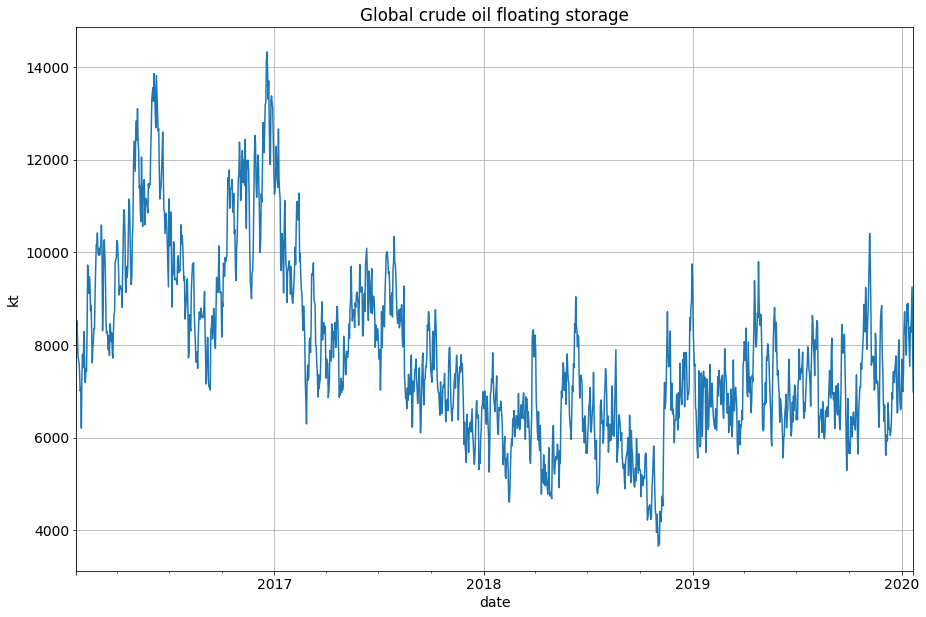

In [48]:
plot_floating_storage(floating_storage)

In [49]:
spot_prices = load_spot_prices_from_EIA()

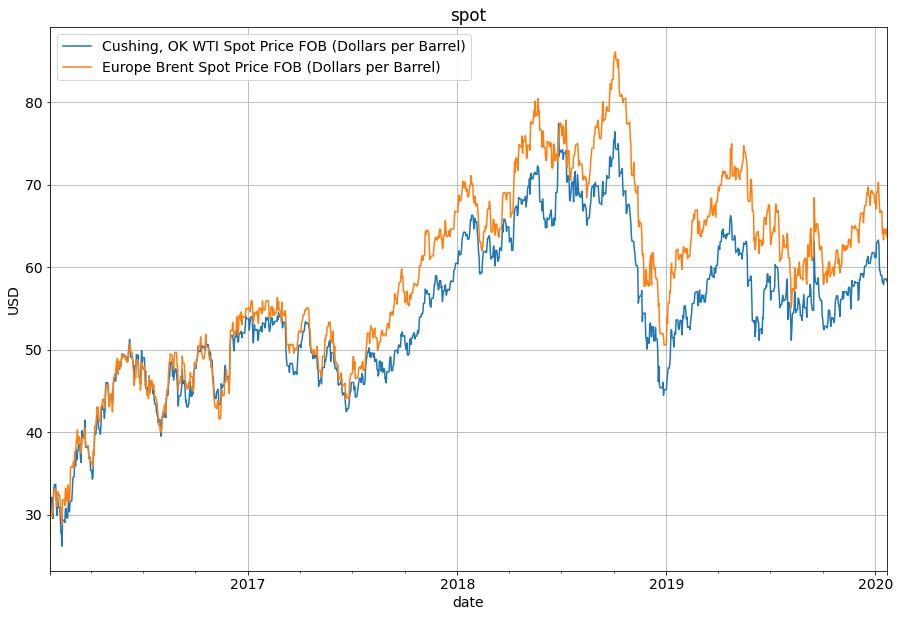

In [50]:
plot_prices(spot_prices, "spot")

In [51]:
spot_prices = spot_prices['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)']

In [52]:
future_prices = load_nymex_future_prices_from_EIA()

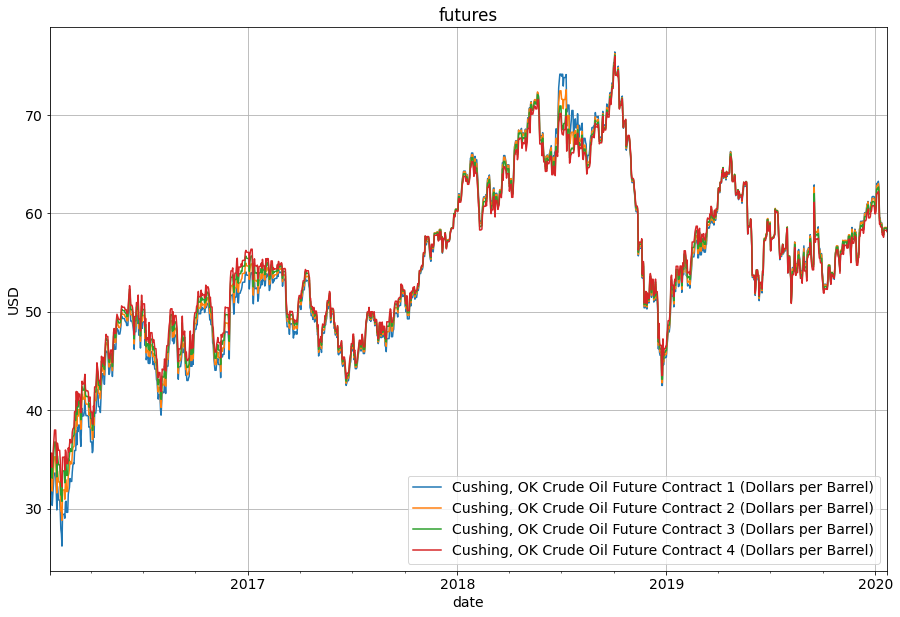

In [53]:
plot_prices(future_prices, "futures")

In [54]:
calendar_spread = future_prices - pd.concat([spot_prices] * 4, axis=1).values

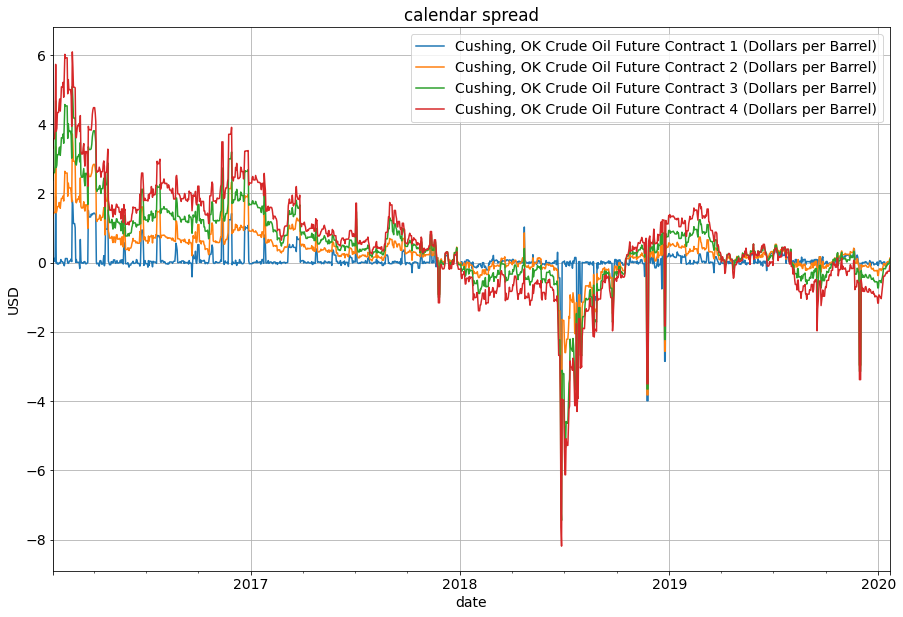

In [55]:
plot_prices(calendar_spread, "calendar spread")

In [56]:
future_prices = future_prices['Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)']
calendar_spread = calendar_spread['Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)']

In [57]:
MAXLAG = 100

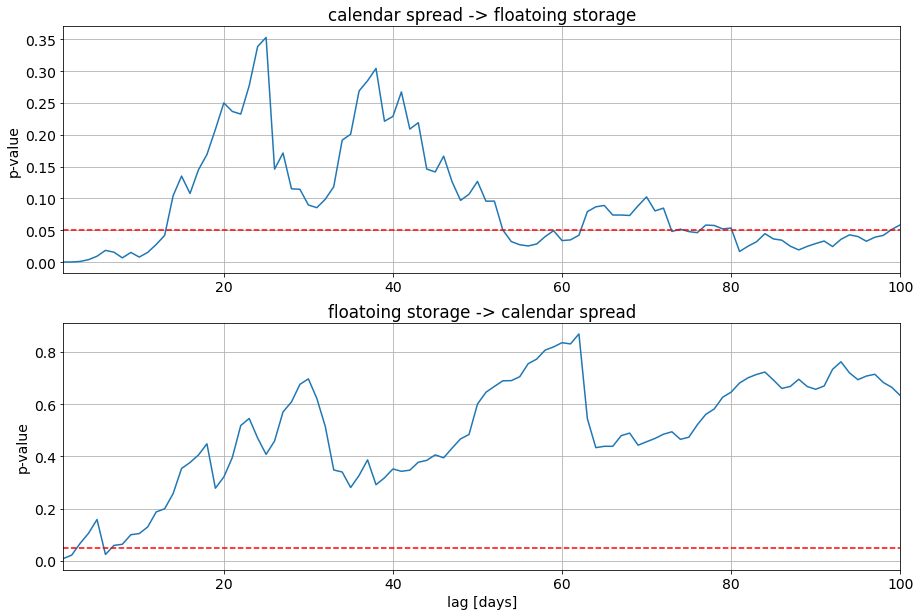

In [59]:
plot_granger_pvalues(calendar_spread, floating_storage, maxlag=MAXLAG, label_x="calendar spread", label_y="floating storage")

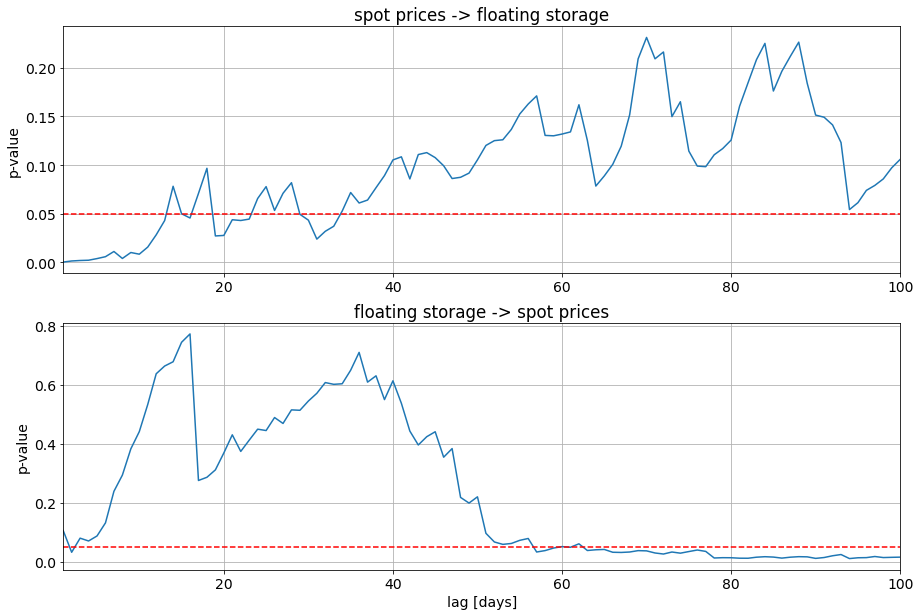

In [60]:
plot_granger_pvalues(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

In [13]:
df_fs = fetch_global_crude_floating_storage_timeseries(START_DATE, END_DATE, UNIT)

2020-04-21 09:54:42,557 vortexasdk.operations — INFO — Searching CargoTimeSeries with params: {'filter_activity': 'storing_state', 'filter_time_min': '2016-04-21T00:00:00.000Z', 'filter_time_max': '2020-04-21T00:00:00.000Z', 'timeseries_activity_time_span_min': None, 'timeseries_activity_time_span_max': None, 'filter_charterers': [], 'filter_owners': [], 'filter_products': ['54af755a090118dcf9b0724c9a4e9f14745c26165385ffa7f1445bc768f06f11'], 'filter_vessels': [], 'filter_destinations': [], 'filter_origins': [], 'filter_storage_locations': [], 'filter_ship_to_ship_locations': [], 'filter_waypoints': [], 'disable_geographic_exclusion_rules': True, 'timeseries_frequency': 'day', 'timeseries_unit': 't', 'timeseries_activity': 'storing_state', 'size': 500}


In [11]:
spot_prices = load_spot_prices_from_EIA()

In [12]:
future_prices = load_nymex_future_prices_from_EIA()